In [1]:
import skimage.io as io 
import matplotlib.pyplot as plt
import skimage as sk
import skimage.color as clr
import matplotlib as mat
import numpy as np
import scipy as sc
import glob
from skimage.filters import try_all_threshold #fonction pour tester une grande variété de fonction pour le threshold d'un coup.

mat.rc('image', cmap='gray')

# Introduction du sujet

L'objectif ici est de compter le nombre de noeuds dans sur le bois. Pour cela nous allons dans un premier temps utilisé une méthode élémentaire et discuté surces avantages et ces inconvénient. L'objectif est d'ensuite à l'aide de publications scientifique et de notre propre intuition scientifique d'améliorer cette méthode pour la rendre le plus précis possible.

nombre d'images 8


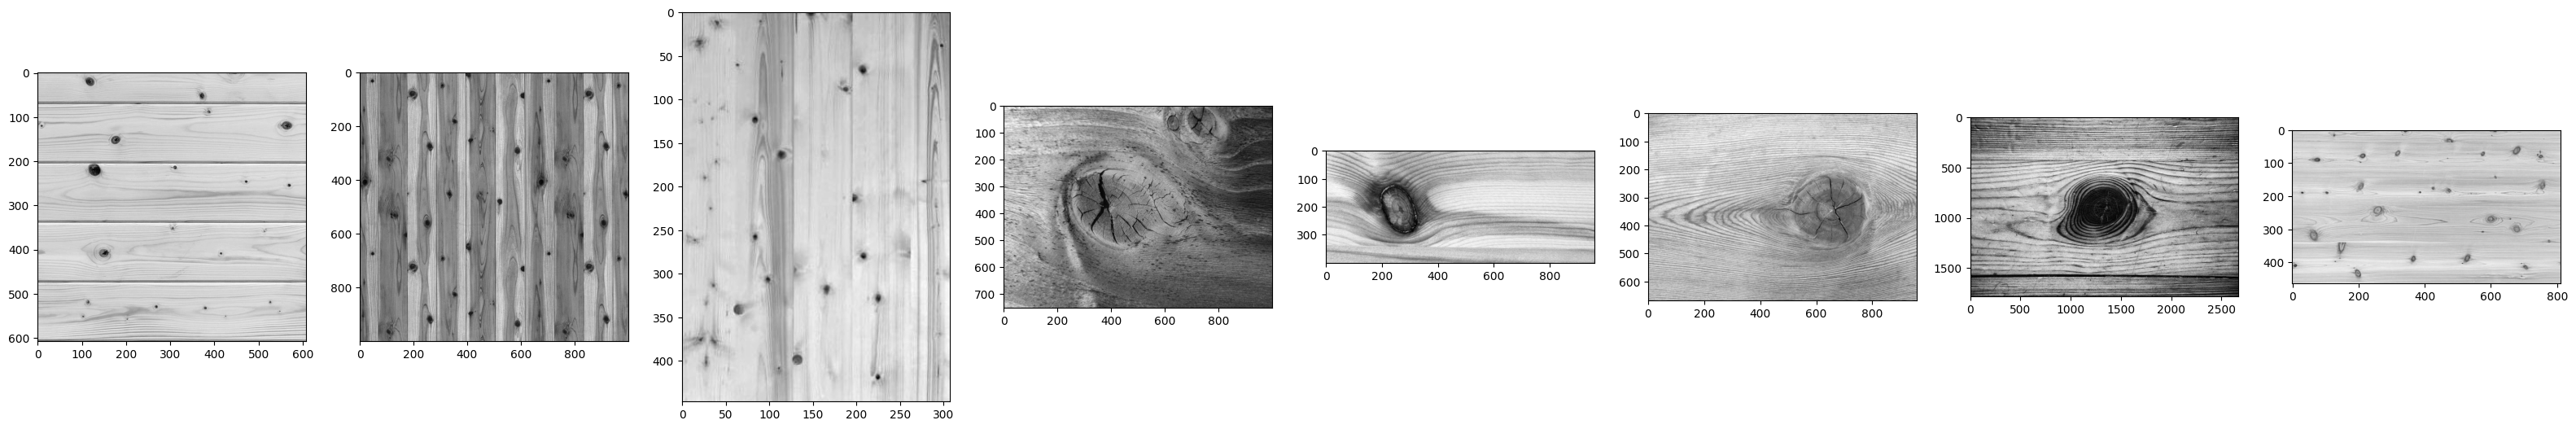

In [2]:
data = glob.glob('dataset/*.jpg') #le chemin pour accéder au images

data_size = len(data) #Le nombre d'image

#Déclaration de toute les listes que nous utiliseront dans la suite. Toute les images sont stocker dans des listes pour être réutiliser à tout moment
#ce n'est pas le plus optimiser pour la géstion de mémoire nous pourrions clear toute liste après utilisation. Ici nous ne le faison pas car nous pourrions en avoir besoin
#pour divers comparaison ou autre.
data_gray = [None] * data_size
data_threshold = [None] * data_size
data_threshold2 = [None] * data_size
data_fill = [None] * data_size
data_fill2 = [None] * data_size
noise_data_t = [None] * data_size
data_float = [None] * data_size
t_test = [None] * data_size

print("nombre d'images",data_size)

fig, ax = plt.subplots(1, data_size,figsize = (40,40))

#Convertion et stockage des images passée en noir et blanc
for i in range(data_size):
    data_gray[i] = clr.rgb2gray(io.imread(data[i]))
    ax[i].imshow((data_gray[i]),cmap = 'gray')

# Traitement des images
Ici nous utilisons une thecnique basique pour le thresholding, qui consiste à prendre la moyenne des intensitées sur les images en noir et blanc comme seuil.

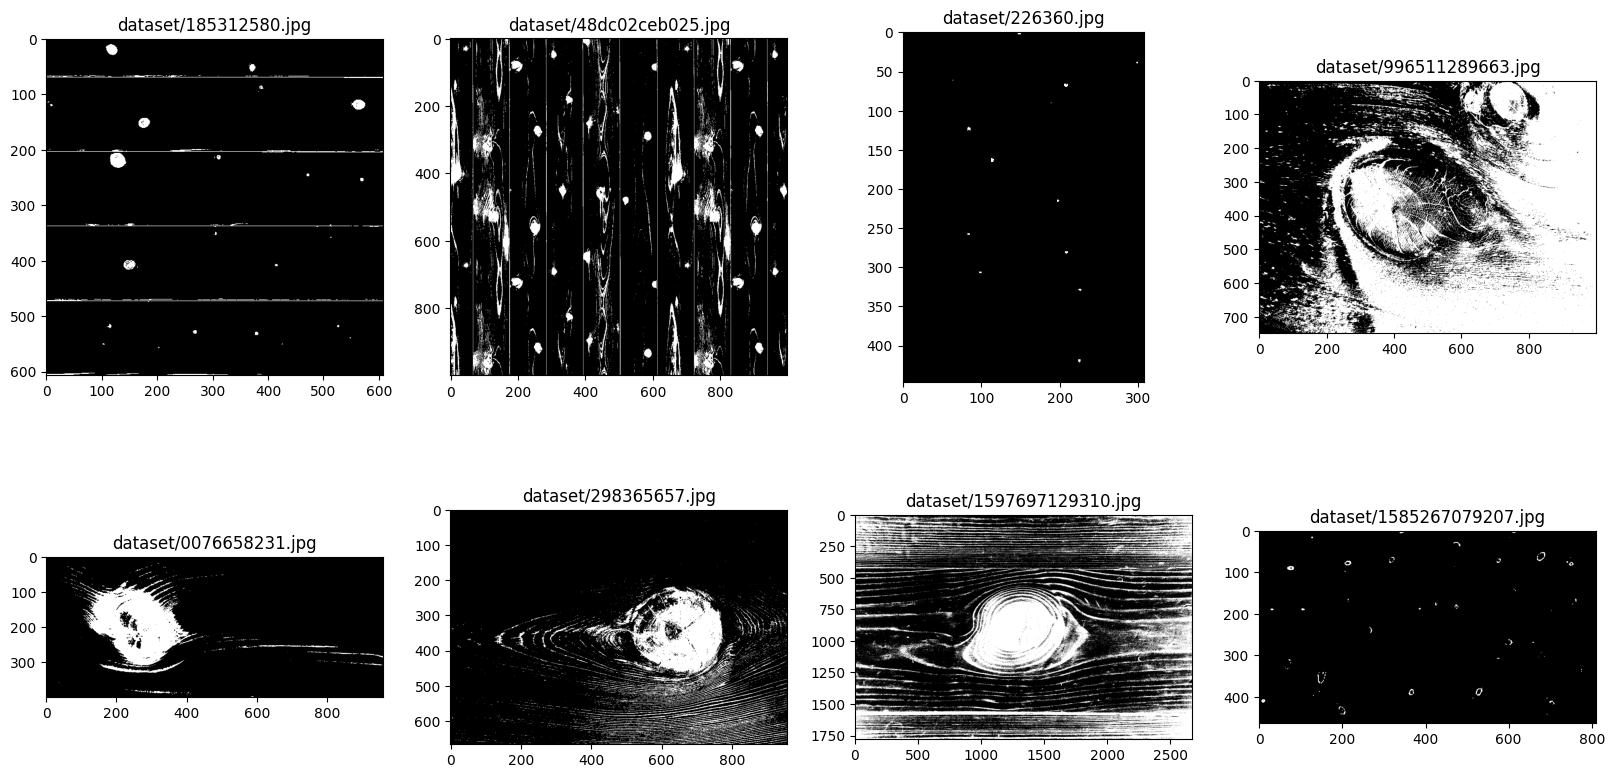

In [3]:
fig, ax = plt.subplots(2, 4,figsize = (20,10))
for i in range(data_size):
    data_mean= np.max(data_gray[i])/2
    data_threshold[i] = data_gray[i] < data_mean
    ax.flatten()[i].imshow((data_threshold[i]),cmap = 'gray')
    ax.flatten()[i].set_title((data[i]))
    


Ces images contenant des troues imparfait vont ensuite être traiter pour remplir tout ces troues.

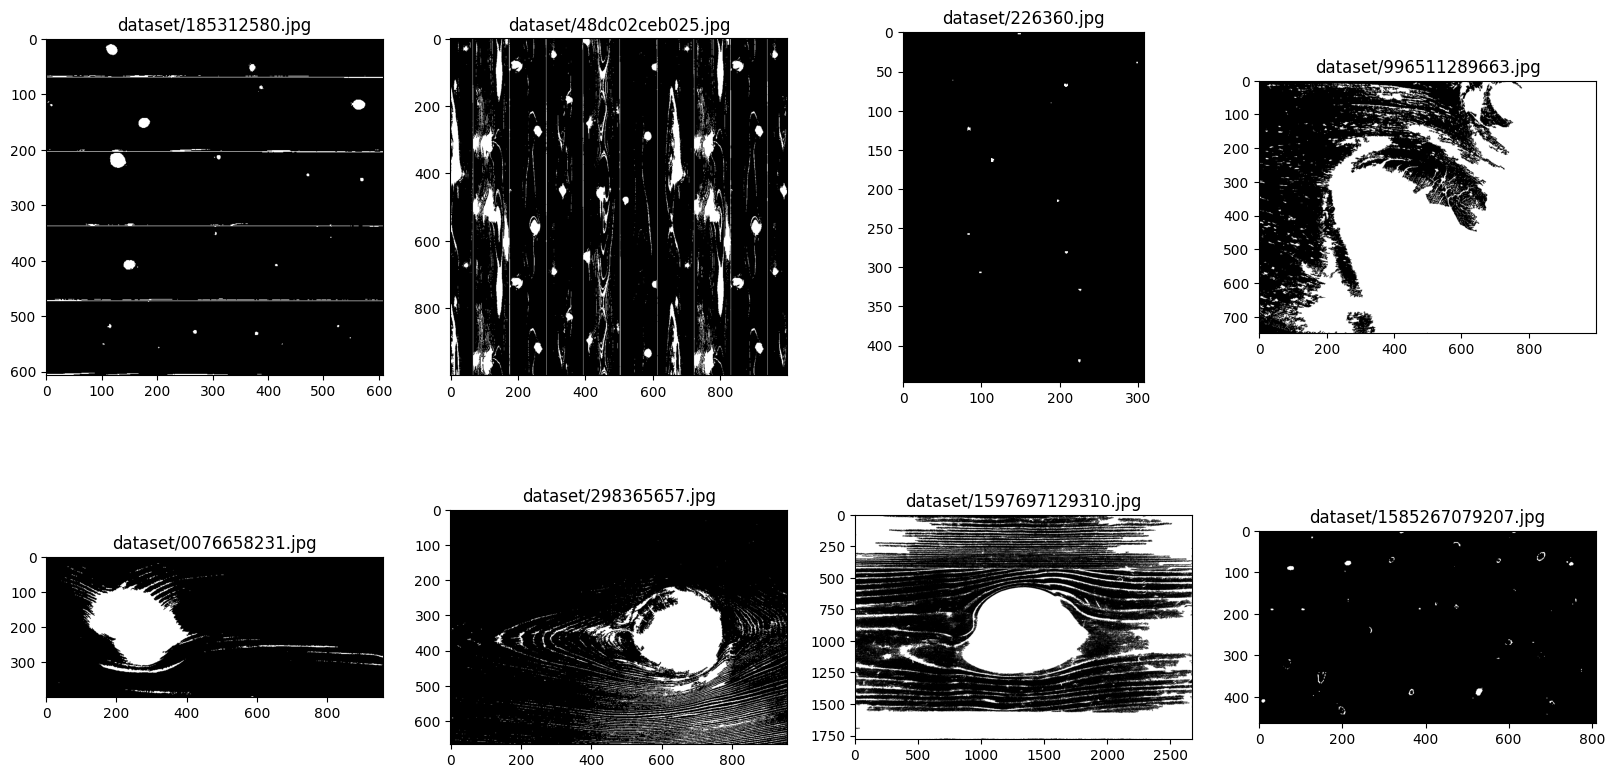

In [4]:
fig, ax = plt.subplots(2, 4,figsize = (20,10))

for i in range(data_size):
    data_fill[i] = sc.ndimage.binary_fill_holes(data_threshold[i]) #Ceci est la fonction qui remplit les troues
    ax.flatten()[i].imshow((data_fill[i]),cmap = 'gray')
    ax.flatten()[i].set_title((data[i]))

Les régions qui nous restes ne sont pas tous des noueds on peux donc les filtrer. C'est l'objectif du prochain code qui filtre les objets avec les conditions suivantes : On ne garde que les régions qui on plus de 5 pixel pour ainsi ne pas garder les régions trop petite et on retire toute les régions avec une excentricité supérieur à 0.9 ce qui nous retira toute les régions trop longue.

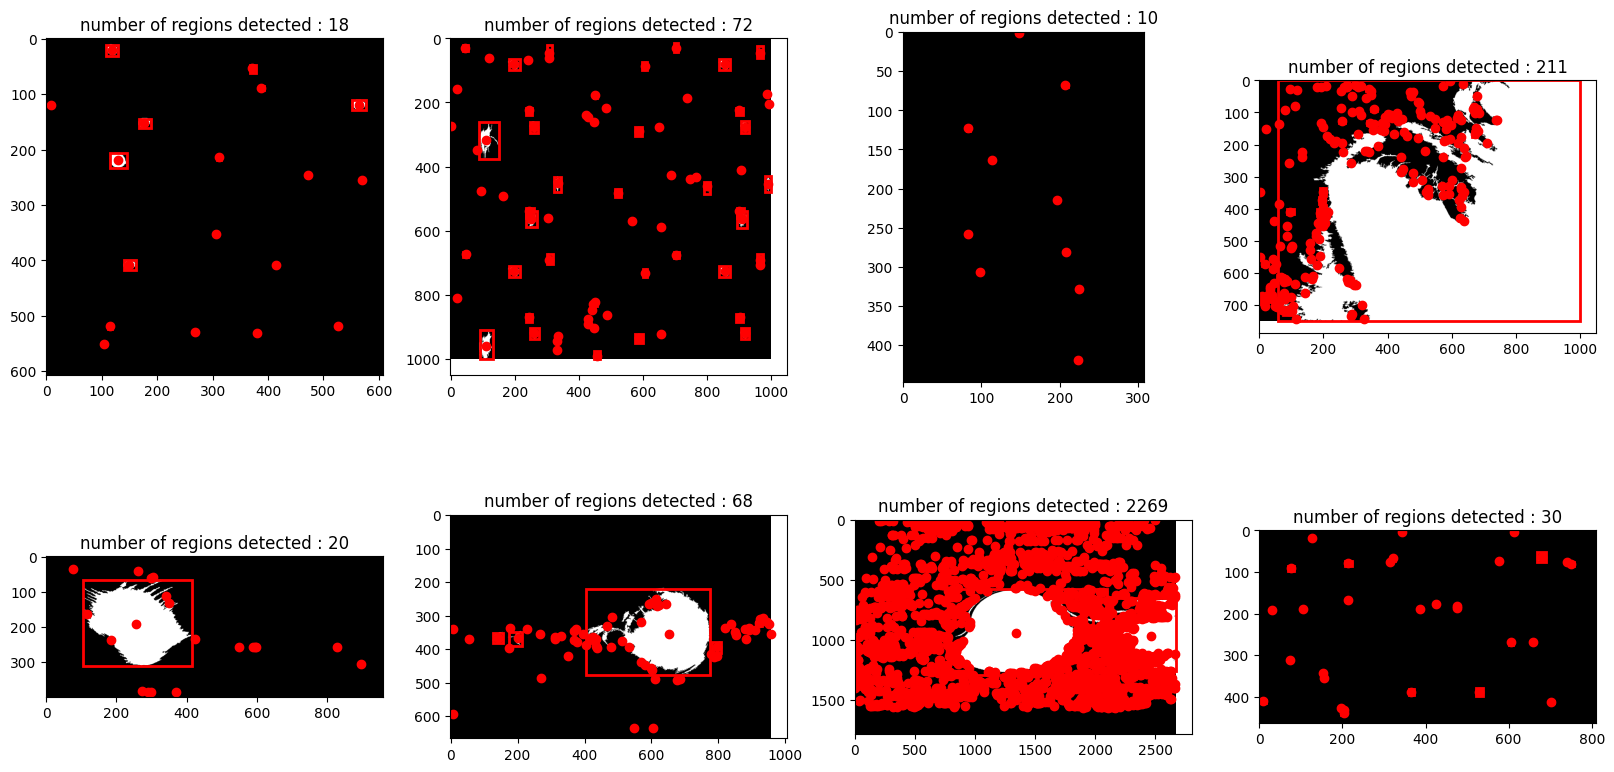

In [5]:
fig, ax = plt.subplots(2, 4,figsize = (20,10))

for i in range(data_size):
    labeled_regions, num_labels = sk.measure.label(data_fill[i], return_num=True) #Ici on récupère toutes les régions connecté et le nombre de régions
    
    region_props = sk.measure.regionprops(labeled_regions) # Ici on récupère les différente informations des régions utile pour le filtrage. 
    
    filtered_regions = [
        region.label
        for region in region_props
        if region.area > 5 and region.eccentricity < 0.9
    ] #ici on garde dans une liste toutes les régions avec les paramètre filtrage expliquer plus haut.
    
    #Ces deux liste sont les centroids et les bounnding_boxes des régions qui nous intérese après filtrage
    centroids = [region.centroid 
                 for region in region_props
                 if region.area > 5 and region.eccentricity < 0.9]
    bounding_boxes = [region.bbox 
                      for region in region_props
                      if region.area > 5 and region.eccentricity < 0.9]
    
    filtered_image = np.isin(labeled_regions, filtered_regions)#Cette ligne permet de garder uniquement les régions filtrer dans nos images.

    #Ici on affiche les images filtrer avec les centroids, bounding_boxes des régions et le nombre de régions trouvé dans chaques images
    ax.flatten()[i].imshow(filtered_image, cmap='gray')
    ax.flatten()[i].set_title(f"number of regions detected : {len(filtered_regions)}")
    for centroid, bbox in zip(centroids, bounding_boxes):
                y, x = centroid
                minr, minc, maxr, maxc = bbox
                rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
                ax.flatten()[i].add_patch(rect)
                ax.flatten()[i].plot(x, y, 'ro')


# Conclusion sur la méthode utilisée
Une fois toute la méthode implémenter nous remarquons beaucoup d'erreurs. Néanmoins ces erreurs sont pour la plus part des faux positifs, cela veux dire que nous trouvons bien les noeuds que nous voulons mais on en repère aussi beaucoup qui n'en sont pas.(On le remarque beaucoup sur les images avec un seul gros noeuds nottament l'image 7 ici) Ceci pourrais venir d'un mauvais filtrage ou deux mauvais paramêtre de thresholding.

On peux facielement voir dans un premier temps que le threshold que l'on effectue n'est pas optimisé essayons des méthode d'optimisaton (mais en gardant le filtrage identique) pour améliorer ce point.

On peux aussi comme dans le LAB7 filter les images avant d'effectuer le threshold. Ces à dire augmenter le gamma ou d'autres paramètres pour essayer d'isoler les noeuds dans un premier temps.

Pour résumer rapidement l'objectif final serait d'obtenir la ground-truth de chaques images.

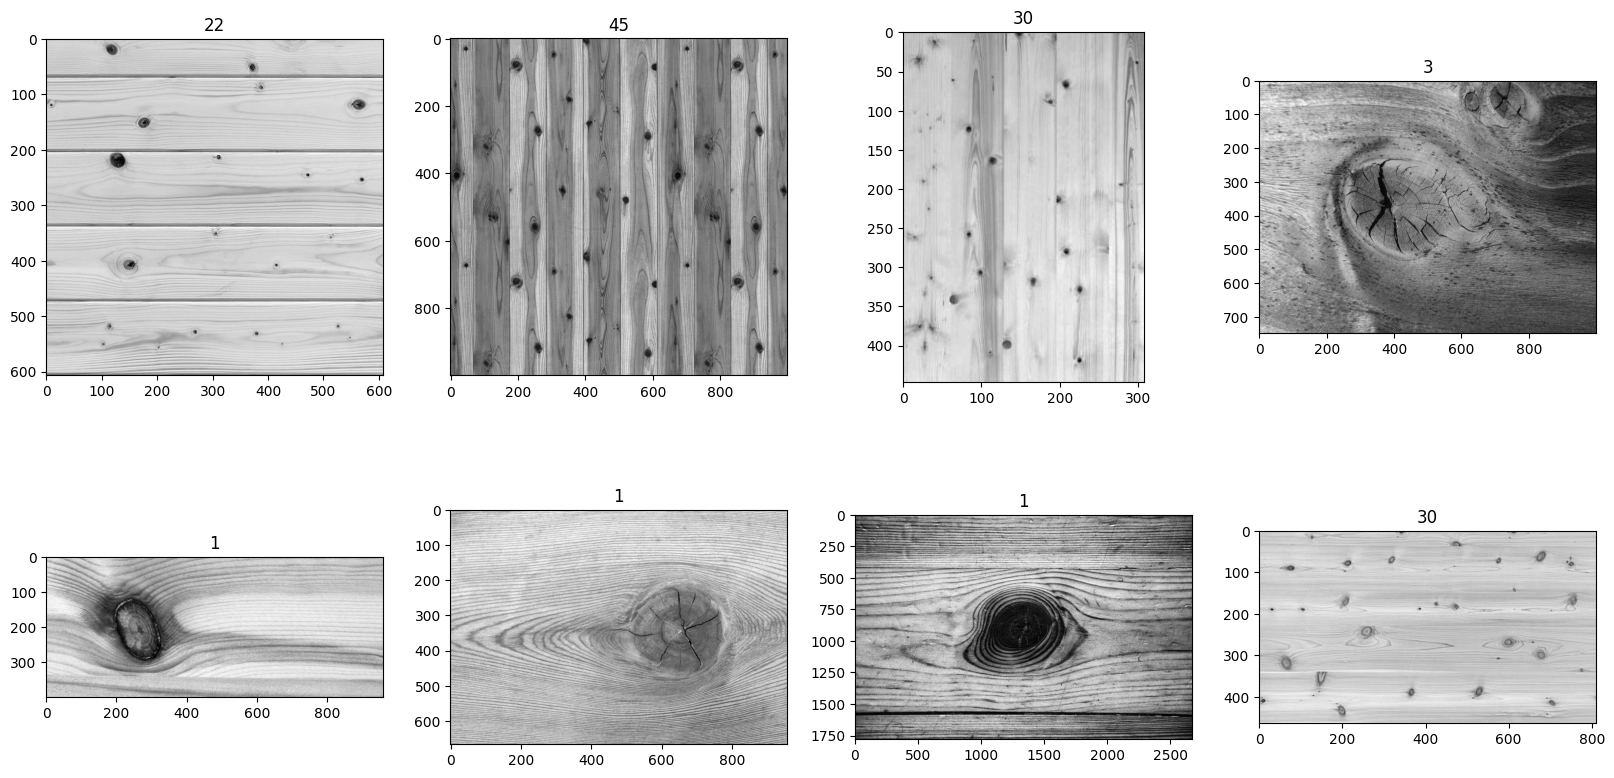

In [6]:
#Ici on affiche juste chaque image avec le nombre de noeuds exact (compter à la main il n'est pas impossible que nous ayons des erreurs)
data_true = [None] * data_size
data_true[0] = 22
data_true[1] = 45
data_true[2] = 30
data_true[3] = 3
data_true[4] = 1
data_true[5] = 1
data_true[6] = 1
data_true[7] = 30
fig, ax = plt.subplots(2, 4,figsize = (20,10))
for i in range(data_size):
    ax.flatten()[i].imshow((data_gray[i]),cmap = 'gray')
    ax.flatten()[i].set_title((data_true[i]))

# Recherche pour l'amélioration de la détection des noeuds
On peux donc avoir une vague idée de la performance de notre méthode en comparant le nombre de noeuds trouvées. On peux déja constaté que notre méthode est éfficaces sur des images avec des couleurs uniformes et de noeuds de taille moyenne. En revanche il à des problèmes lors des grandes variation de couleur et pour les gros noeuds. On peux vérifier cela en appliquand du bruit ou divers changement à nos images. Pour cela je vais utiliser la dernière image car c'est avec elle que nous avons la plus grande précision (en nombre pour la position des noeuds c'est autres choses)

In [7]:
SNR = 90
for i in range(data_size):
    data_float[i] = data_gray[i].astype(float)
    ps = np.linalg.norm(data_float[i])**2/(data_float[i].shape[0]*data_float[i].shape[1])
    var = pow(10,(-SNR/10)) * ps
    noise_data_t[i] = sk.util.random_noise(data_float[i], clip='False',var = var )

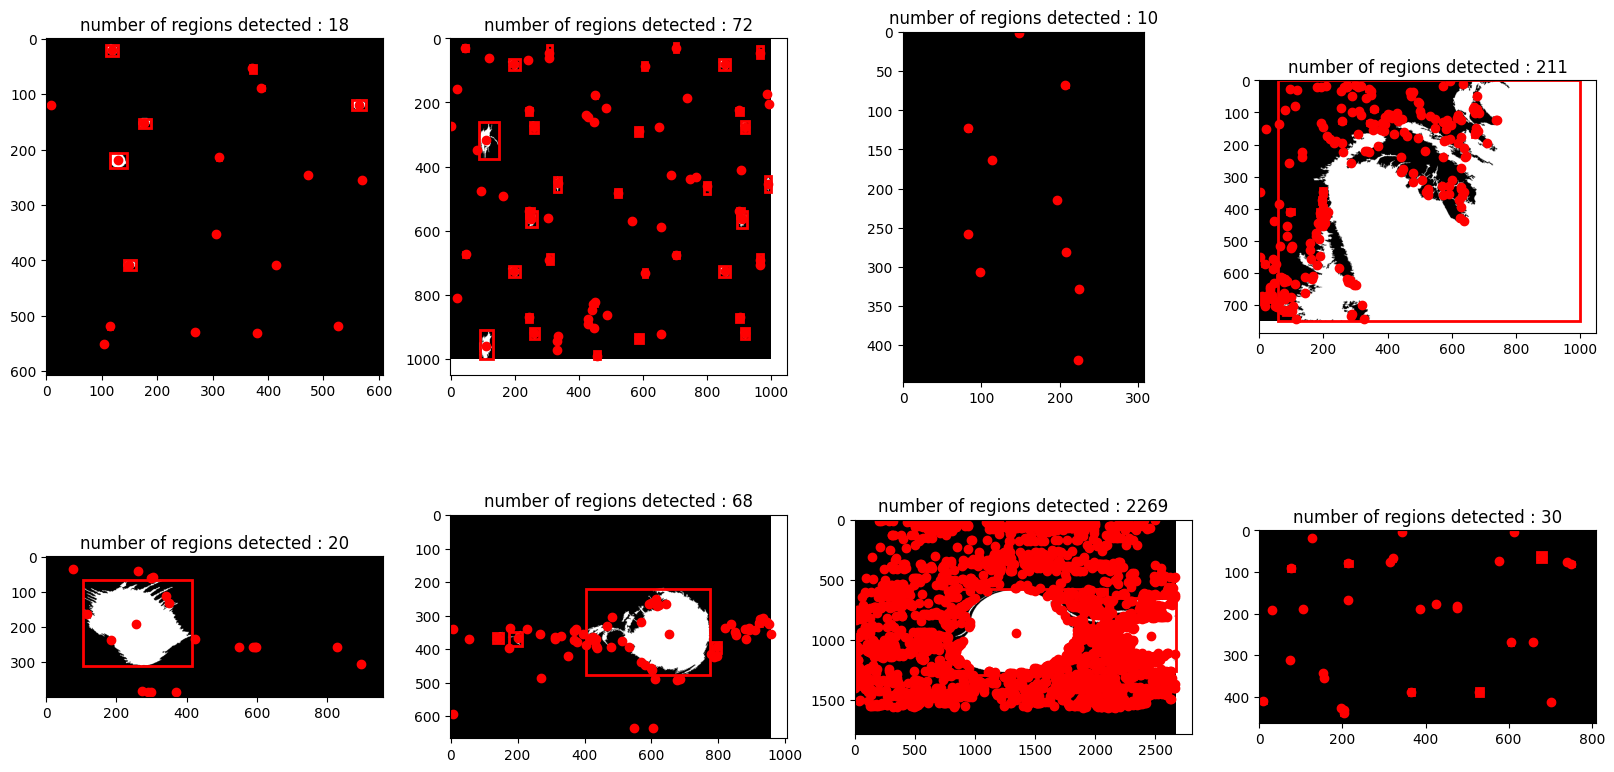

In [8]:
fig, ax = plt.subplots(2, 4,figsize = (20,10))

for i in range(data_size):
    data_mean= np.max(noise_data_t[i])/2
    data_threshold[i] = noise_data_t[i] < data_mean
    data_fill[i] = sc.ndimage.binary_fill_holes(data_threshold[i])
    
    labeled_regions, num_labels = sk.measure.label(data_fill[i], return_num=True)
    
    region_props = sk.measure.regionprops(labeled_regions)
    
    filtered_regions = [
        region.label
        for region in region_props
        if region.area > 5 and region.eccentricity < 0.9
    ]
    
    centroids = [region.centroid 
                 for region in region_props
                 if region.area > 5 and region.eccentricity < 0.9]
    bounding_boxes = [region.bbox 
                      for region in region_props
                      if region.area > 5 and region.eccentricity < 0.9]
    
    filtered_image = np.isin(labeled_regions, filtered_regions)

    
    ax.flatten()[i].imshow(filtered_image, cmap='gray')
    ax.flatten()[i].set_title(f"number of regions detected : {len(filtered_regions)}")
    for centroid, bbox in zip(centroids, bounding_boxes):
                y, x = centroid
                minr, minc, maxr, maxc = bbox
                rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
                ax.flatten()[i].add_patch(rect)
                ax.flatten()[i].plot(x, y, 'ro')


On remarque ici que le bruit n'a pas une très grande influence sur le nombre de noeuds détéctées. En revanche si l'on reviens au début de la méthode on remarque que le thresholding pose déja un problème avec la méthode utilisé. En effet il laisse même après le tri des régions des points d'intéret qui ne sont pas des noeuds on peut donc dans un premier temps essayer de garder le filtrage que l'on à mais changer la méthode de thresholding. Pour ce faire je vais utiliser une fonction qui test une varité de méthodes pour le thresholding. Pour cela on utilisera la fonction [try_all_threshold]( https://github.com/scikit-image/scikit-image/blob/v0.19.0/skimage/filters/thresholding.py#L97-L154).

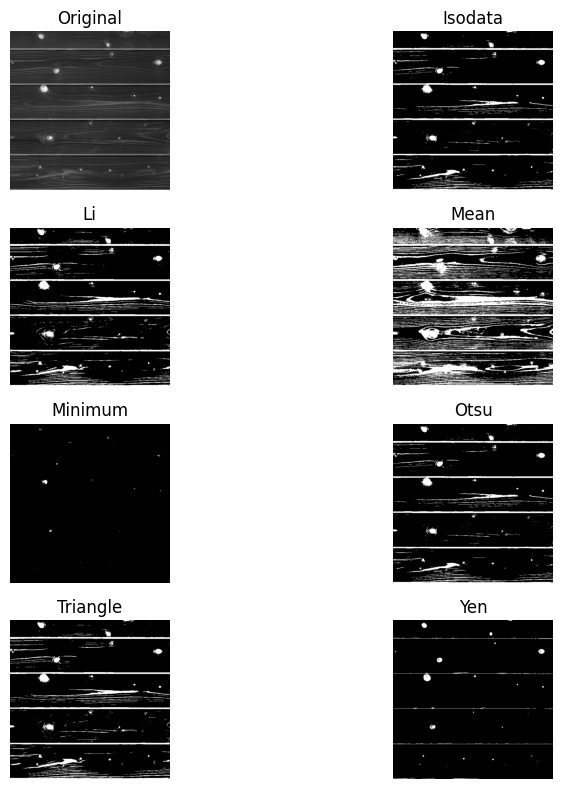

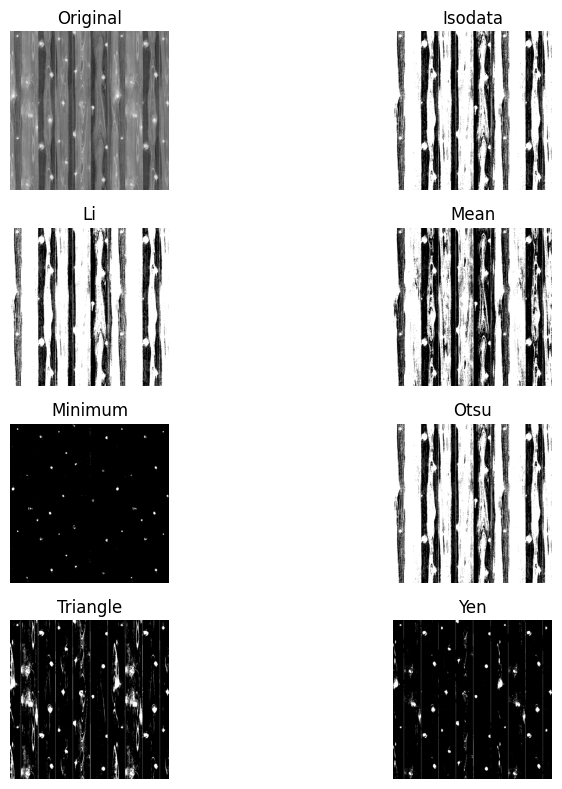

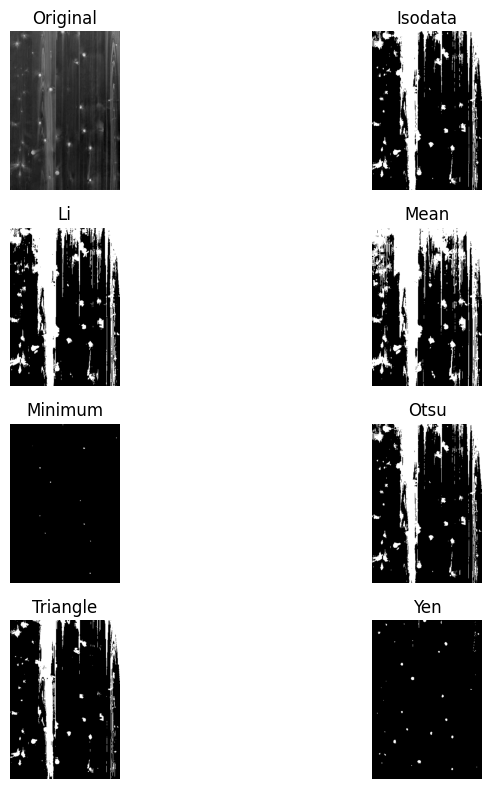

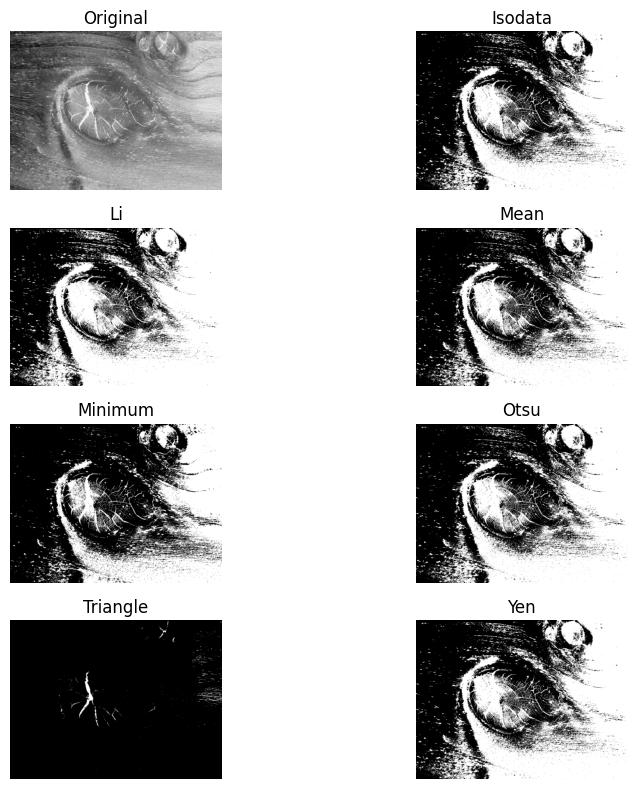

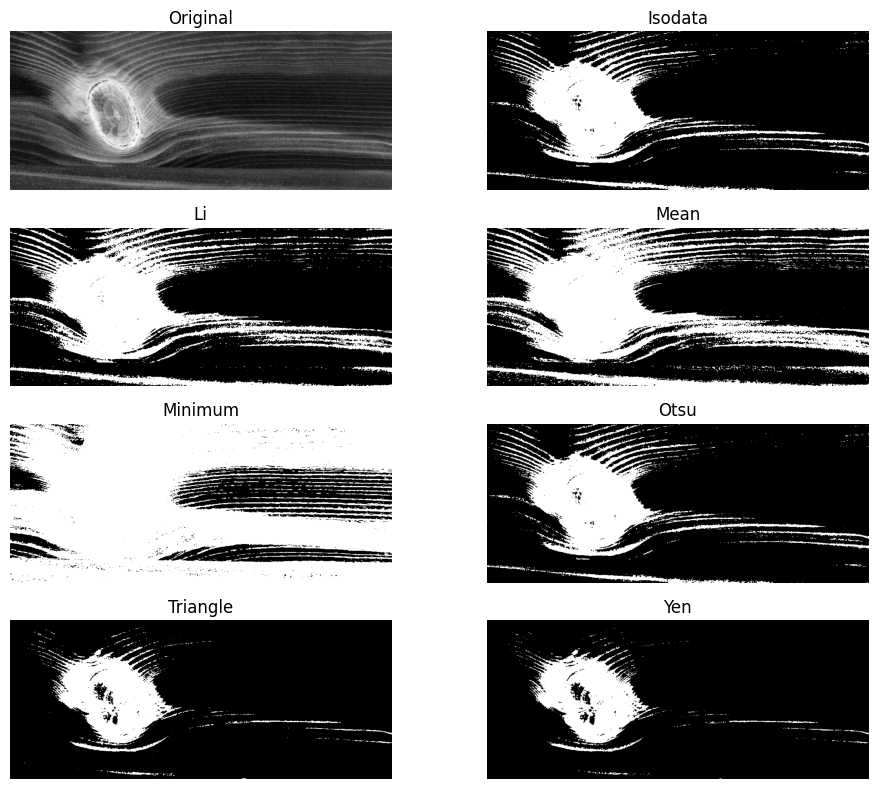

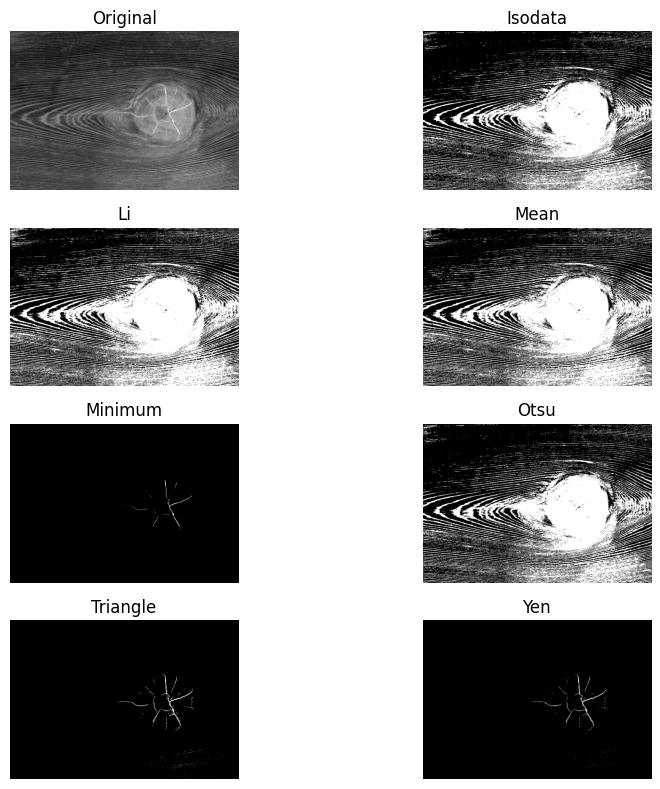

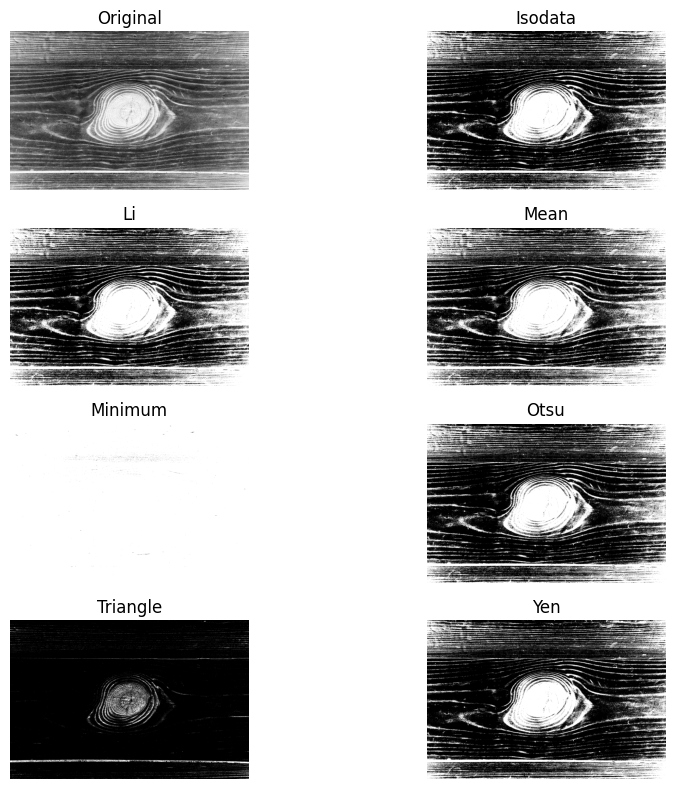

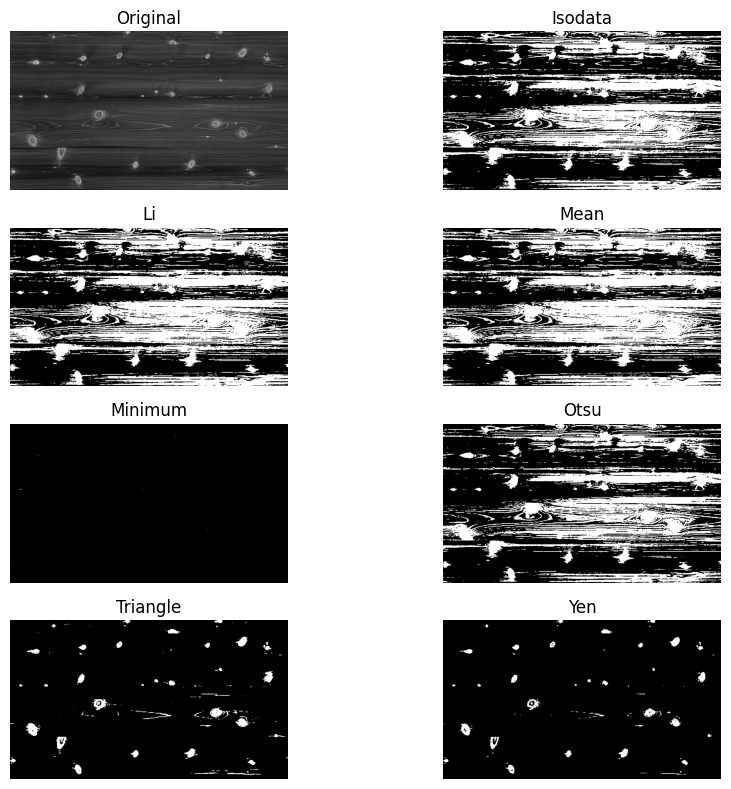

In [9]:
#Ici j'utilise une fonction pour tester plusiseurs méthode d'optimisation du thresholding pour ensuite en déduire la quel serait la plus optimiser pour chaque image
for i in range(data_size):
    fig, ax = try_all_threshold(1-data_gray[i], figsize=(10, 8), verbose=False) 

On remarque dès lors que chaque image à une méthodes différentes qui fonctionne au mieux sur elle. Je vais donc dans un premier temps utiliser les bonnes fonctions sur les bonnes images pour récuperer les bons seuils

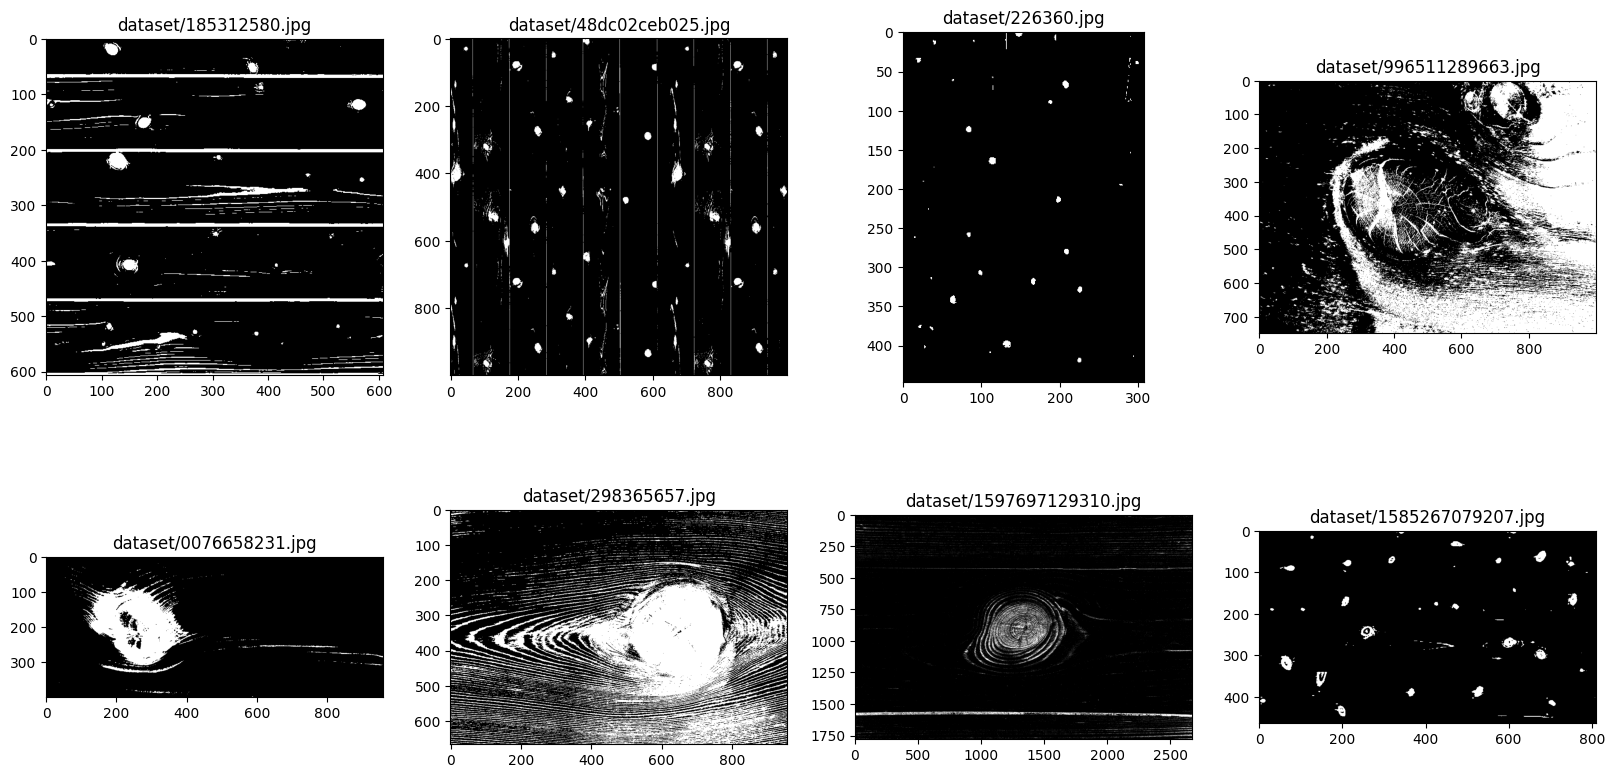

In [10]:
#Ici je mets dans une liste toutes les images avec leur méthode de thresholding associer.
t_test[0] = sk.filters.threshold_otsu(data_gray[0])
t_test[1] = sk.filters.threshold_yen(data_gray[1])
t_test[2] = sk.filters.threshold_yen(data_gray[2])
t_test[3] = sk.filters.threshold_minimum(data_gray[3],max_num_iter=5000)
t_test[4] = sk.filters.threshold_yen(data_gray[4])
t_test[5] = sk.filters.threshold_otsu(data_gray[5])
t_test[6] = sk.filters.threshold_triangle(data_gray[6])
t_test[7] = sk.filters.threshold_yen(data_gray[7])

fig, ax = plt.subplots(2, 4,figsize = (20,10))

for i in range(data_size):
    data_threshold2[i] = data_gray[i] < t_test[i]
    ax.flatten()[i].imshow((data_threshold2[i]),cmap = 'gray')
    ax.flatten()[i].set_title((data[i]))


On rapplique ensuite les mêmes étapes qu'avec la première méthode

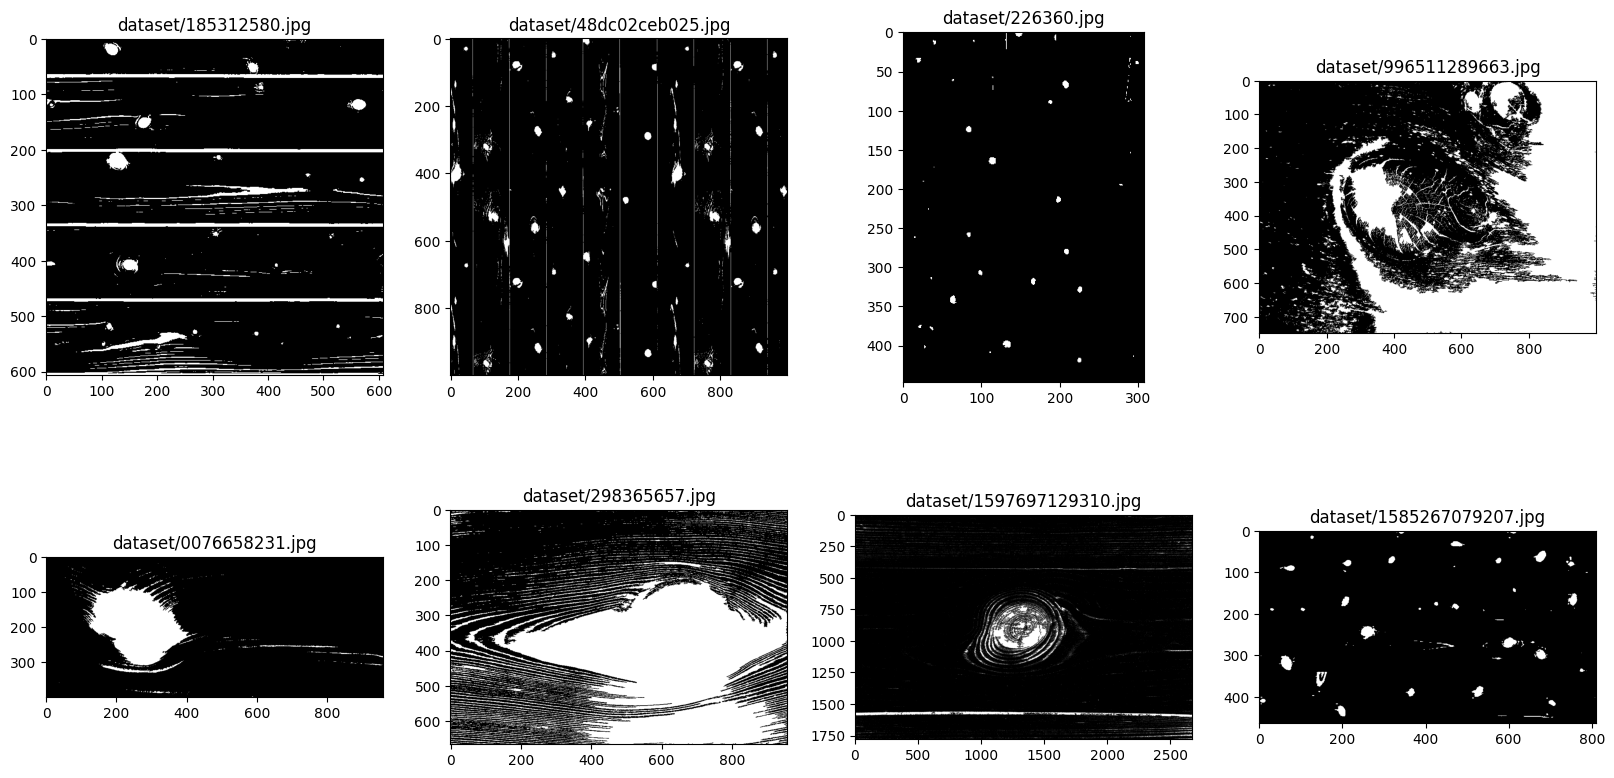

In [11]:
fig, ax = plt.subplots(2, 4,figsize = (20,10))
for i in range(data_size):
    data_fill2[i] = sc.ndimage.binary_fill_holes(data_threshold2[i])
    ax.flatten()[i].imshow((data_fill2[i]),cmap = 'gray')
    ax.flatten()[i].set_title((data[i]))

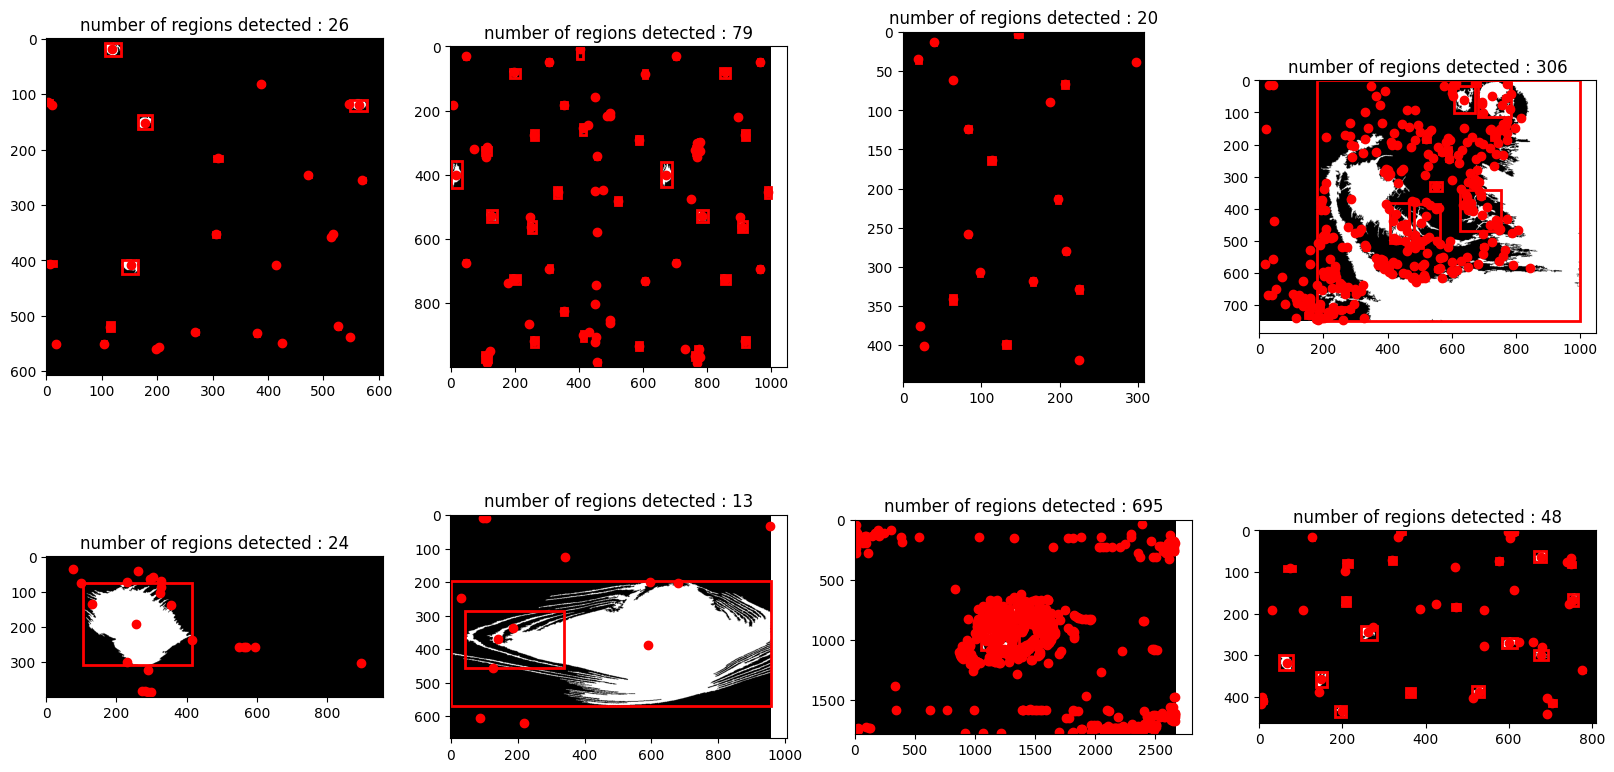

In [12]:
fig, ax = plt.subplots(2, 4,figsize = (20,10))

for i in range(data_size):
    labeled_regions, num_labels = sk.measure.label(data_fill2[i], return_num=True)
    
    region_props = sk.measure.regionprops(labeled_regions)
    
    filtered_regions = [
        region.label
        for region in region_props
        if region.area > 5 and region.eccentricity < 0.9
    ]
    
    centroids = [region.centroid 
                 for region in region_props
                 if region.area > 5 and region.eccentricity < 0.9]
    bounding_boxes = [region.bbox 
                      for region in region_props
                      if region.area > 5 and region.eccentricity < 0.9]
    
    filtered_image = np.isin(labeled_regions, filtered_regions)

    
    ax.flatten()[i].imshow(filtered_image, cmap='gray')
    ax.flatten()[i].set_title(f"number of regions detected : {len(filtered_regions)}")
    for centroid, bbox in zip(centroids, bounding_boxes):
                y, x = centroid
                minr, minc, maxr, maxc = bbox
                rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
                ax.flatten()[i].add_patch(rect)
                ax.flatten()[i].plot(x, y,'ro')


On remarque que cette approche n'a pas rendu la méthode parfaite mais à réussi à améliorer la détection des noeuds sur certaines images, en effet sur les images avec des gros noeuds on détectes moins de faux positifs. Cette méthode pourrais alors être fusionner avec une autre méthodes pour réduire encore plus les faux positifs.

# Des méthodes plus efficaces
Nous voyons que malgrès les améliorations apportées nous n'avons toujours pas de prédiction parfaite. Nous avons donc rechercher d'autres méthodes pour nous aider. Nous ne somme tomber que sur des projets utilisant l'intélligence artifcielle et pour cause qu'importe la méthode on sera toujours éloigner de la ground truth. Dans un premier temps pour nous rendre compte de la puissance de tels outils nous avons essayer de trouver les noeuds dans les images grâce à [Segmennt anything](https://segment-anything.com/demo) de Meta et ces différents outils. On n'obtenez des résultats très rapides et très satisfaisant nottament quand les images n'avais que quelque gros noeuds. Nous nous somme aussi pencher sur le documents ["Detection of Knots in Oak Wood Planks: Instance versus Semantic segmentation"](https://ieeexplore-ieee-org.scd-rproxy.u-strasbg.fr/document/9862633) qui étudit la différences de perfomance entre deux méthodes de détection de noeuds. On apprend dans ce documents différents model pour les IA (SSD, Mask R-CNN, YOLO...) mais aussi que ce soit la méthode par Ségmentation d'instance ou sémantique on entre 89% et 90% de précision sur la détéction de noeuds. Néanmoins on à une faible précision sur la détéction des bounting box (entre 49% et 59%).

Malgré la perfomance de ces modèles il ne faut noté que pour les crées il faut d'abord un jeu de données avec les ground-truth des images pour l'apprentissage. Ce qui implique ici de faire une détections des noeuds de notre jeu données à la mains.
